In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelClassificationHead(nn.Module):
    def __init__(self, input_dim, num_descriptors=18, options_per_descriptor=4):
        super(MultiLabelClassificationHead, self).__init__()
        self.num_descriptors = num_descriptors
        self.options_per_descriptor = options_per_descriptor
        
        # Create separate linear layers for each descriptor
        self.descriptor_layers = nn.ModuleList([
            nn.Linear(input_dim, options_per_descriptor) for _ in range(num_descriptors)
        ])
        
    def forward(self, x):
        # x shape: (batch_size, input_dim)
        outputs = []
        for layer in self.descriptor_layers:
            descriptor_output = layer(x)  # shape: (batch_size, options_per_descriptor)
            descriptor_output = F.softmax(descriptor_output, dim=1)  # Apply softmax for each descriptor
            outputs.append(descriptor_output)
        
        # Stack outputs along a new dimension
        return torch.stack(outputs, dim=1)  # shape: (batch_size, num_descriptors, options_per_descriptor)

# Example usage
input_dim = 512  # This should match the output dimension of your backbone network
classification_head = MultiLabelClassificationHead(input_dim)

# Assuming 'features' is the output from your backbone network
batch_size = 32
features = torch.randn(batch_size, input_dim)
outputs = classification_head(features)

print(f"Output shape: {outputs.shape}")  # Should be (batch_size, 18, 4)

# Loss function
class MultiLabelSoftmaxLoss(nn.Module):
    def __init__(self):
        super(MultiLabelSoftmaxLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, predictions, targets):
        # predictions shape: (batch_size, num_descriptors, options_per_descriptor)
        # targets shape: (batch_size, num_descriptors)
        loss = 0
        for i in range(predictions.size(1)):
            loss += self.ce_loss(predictions[:, i, :], targets[:, i])
        return loss.mean()

# Example of computing loss
criterion = MultiLabelSoftmaxLoss()
targets = torch.randint(0, 4, (batch_size, 18))  # Random targets for illustration
print(f"Targets shape: {targets.shape}")
print(f"outputs shape: {outputs.shape}")
loss = criterion(outputs, targets)
print(f"Loss: {loss.item()}")

Output shape: torch.Size([32, 18, 4])
Loss: 24.95261001586914


In [15]:
import torch
import numpy as np
from torchmetrics.classification import (
    MultilabelAveragePrecision,
    MultilabelAUROC,
    MultilabelPrecision,
    MultilabelRecall,
    MultilabelF1Score,
    MultilabelAccuracy
)
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 参数设置
num_classes = 18
num_samples = 10000  # 使用较大的样本量以获得更稳定的结果

# 创建模拟数据
# preds = torch.rand(num_samples, num_classes)
target = torch.randint(0, 2, (num_samples, num_classes)).int()

def generate_biased_preds(target, noise_level):
    # 从目标生成有偏见的预测
    noise = torch.rand(target.shape) * noise_level
    preds = target + noise - (noise_level / 2)
    return torch.clamp(preds, 0, 1)

# 通过二分搜索找到合适的噪声水平
left, right = 0, 2
target_f1 = 0.7
tolerance = 0.001

while right - left > tolerance:
    noise_level = (left + right) / 2
    preds = generate_biased_preds(target, noise_level)
    
    f1 = MultilabelF1Score(num_labels=num_classes, average='macro', threshold=0.5)
    current_f1 = f1(preds, target).item()
    
    if current_f1 > target_f1:
        left = noise_level
    else:
        right = noise_level

# 使用找到的最佳噪声水平生成最终预测
final_noise_level = (left + right) / 2
preds = generate_biased_preds(target, final_noise_level)
# 转换为NumPy数组以供scikit-learn使用
preds_np = preds.numpy()
target_np = target.numpy()

# TorchMetrics计算
tm_map = MultilabelAveragePrecision(num_labels=num_classes, average='macro')
tm_auroc = MultilabelAUROC(num_labels=num_classes, average='macro')
tm_precision = MultilabelPrecision(num_labels=num_classes, average='macro', threshold=0.5)
tm_recall = MultilabelRecall(num_labels=num_classes, average='macro', threshold=0.5)
tm_f1 = MultilabelF1Score(num_labels=num_classes, average='macro', threshold=0.5)
tm_accuracy = MultilabelAccuracy(num_labels=num_classes, average='micro', threshold=0.5)

tm_map_score = tm_map(preds, target)
tm_auroc_score = tm_auroc(preds, target)
tm_precision_score = tm_precision(preds, target)
tm_recall_score = tm_recall(preds, target)
tm_f1_score = tm_f1(preds, target)
tm_accuracy_score = tm_accuracy(preds, target)

# Scikit-learn计算
sk_map_score = average_precision_score(target_np, preds_np, average='macro')
sk_auroc_score = roc_auc_score(target_np, preds_np, average='macro')
sk_precision_score = precision_score(target_np, preds_np > 0.5, average='macro')
sk_recall_score = recall_score(target_np, preds_np > 0.5, average='macro')
sk_f1_score = f1_score(target_np, preds_np > 0.5, average='macro')
sk_accuracy_score = accuracy_score(target_np, preds_np > 0.5)

# 打印结果比较
print("Metric      | TorchMetrics | Scikit-learn | Difference")
print("------------|--------------|--------------|------------")
print(f"mAP         | {tm_map_score:.6f}   | {sk_map_score:.6f}   | {abs(tm_map_score - sk_map_score):.6f}")
print(f"AUROC       | {tm_auroc_score:.6f}   | {sk_auroc_score:.6f}   | {abs(tm_auroc_score - sk_auroc_score):.6f}")
print(f"Precision   | {tm_precision_score:.6f}   | {sk_precision_score:.6f}   | {abs(tm_precision_score - sk_precision_score):.6f}")
print(f"Recall      | {tm_recall_score:.6f}   | {sk_recall_score:.6f}   | {abs(tm_recall_score - sk_recall_score):.6f}")
print(f"F1 Score    | {tm_f1_score:.6f}   | {sk_f1_score:.6f}   | {abs(tm_f1_score - sk_f1_score):.6f}")
print(f"Accuracy    | {tm_accuracy_score:.6f}   | {sk_accuracy_score:.6f}   | {abs(tm_accuracy_score - sk_accuracy_score):.6f}")

# 计算每个类别的正例比例
positive_ratio = target.float().mean(dim=0)
print(f"\nPositive ratio for each class: {positive_ratio}")

Metric      | TorchMetrics | Scikit-learn | Difference
------------|--------------|--------------|------------
mAP         | 0.888043   | 0.888043   | 0.000000
AUROC       | 0.875870   | 0.875870   | 0.000000
Precision   | 0.751422   | 0.751422   | 0.000000
Recall      | 0.750324   | 0.750324   | 0.000000
F1 Score    | 0.750861   | 0.750861   | 0.000000
Accuracy    | 0.751000   | 0.006300   | 0.744700

Positive ratio for each class: tensor([0.4963, 0.5017, 0.5010, 0.5007, 0.5088, 0.4969, 0.4915, 0.5014, 0.4985,
        0.4950, 0.4974, 0.5014, 0.4992, 0.4984, 0.5051, 0.4989, 0.5056, 0.5047])


target

In [14]:
target

tensor([[0, 0, 1,  ..., 1, 0, 1],
        [0, 0, 1,  ..., 0, 1, 0],
        [1, 0, 1,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 1],
        [0, 0, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 1]], dtype=torch.int32)

In [16]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def generate_data(num_samples, num_classes, p_ratio):
    # 生成目标数据和预测数据
    target = np.random.randint(0, 2, size=(num_samples, num_classes))
    preds = np.random.random(size=(num_samples, num_classes))
    
    # 计算 p 值
    p = np.arange(num_samples) / num_samples * p_ratio
    
    # 生成最终的预测和目标
    final_preds = np.zeros_like(target)
    final_target = np.zeros_like(target)
    
    for i in range(num_samples):
        for j in range(num_classes):
            if np.random.random() < 1 - p[i]:
                final_preds[i, j] = target[i, j]
                final_target[i, j] = target[i, j]
            else:
                final_preds[i, j] = int(preds[i, j] > 0.5)
                final_target[i, j] = target[i, j]
    
    return final_preds, final_target

def calculate_metrics(preds, target):
    precision = precision_score(target, preds, average='samples')
    recall = recall_score(target, preds, average='samples')
    f1 = f1_score(target, preds, average='samples')
    return precision, recall, f1

# 设置参数
num_samples = 1000
num_classes = 10
p_ratio = 0.5

# 生成数据
preds, target = generate_data(num_samples, num_classes, p_ratio)

# 计算指标
precision, recall, f1 = calculate_metrics(preds, target)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8777
Recall: 0.8771
F1 Score: 0.8653


C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Round 1, P Ratio: 0.10
  Precision: 0.9751
  Recall: 0.9739
  F1 Score: 0.9718

Round 2, P Ratio: 0.20
  Precision: 0.9518
  Recall: 0.9492
  F1 Score: 0.9451

Round 3, P Ratio: 0.30
  Precision: 0.9297
  Recall: 0.9218
  F1 Score: 0.9177

Round 4, P Ratio: 0.40
  Precision: 0.9000
  Recall: 0.8999
  F1 Score: 0.8907

Round 5, P Ratio: 0.50
  Precision: 0.8769
  Recall: 0.8687
  F1 Score: 0.8603

Round 6, P Ratio: 0.60
  Precision: 0.8476
  Recall: 0.8490
  F1 Score: 0.8357

Round 7, P Ratio: 0.70
  Precision: 0.8210
  Recall: 0.8208
  F1 Score: 0.8056

Round 8, P Ratio: 0.80
  Precision: 0.8014
  Recall: 0.8006
  F1 Score: 0.7853

Round 9, P Ratio: 0.90
  Precision: 0.7776
  Recall: 0.7739
  F1 Score: 0.7583

Round 10, P Ratio: 1.00
  Precision: 0.7370
  Recall: 0.7335
  F1 Score: 0.7172



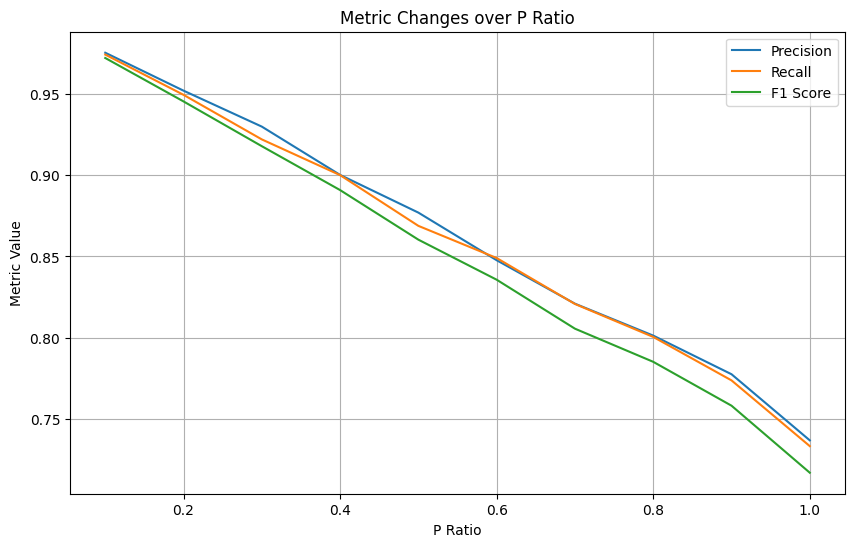

In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def generate_data(num_samples, num_classes):
    # 生成目标数据和初始预测数据
    target = np.random.randint(0, 2, size=(num_samples, num_classes))
    preds = np.random.random(size=(num_samples, num_classes))
    return target, preds

def evaluate_round(target, preds, p_ratio):
    num_samples, num_classes = target.shape
    p = np.arange(num_samples) / num_samples * p_ratio
    
    final_preds = np.zeros_like(target)
    
    for i in range(num_samples):
        for j in range(num_classes):
            if np.random.random() < 1 - p[i]:
                final_preds[i, j] = target[i, j]
            else:
                final_preds[i, j] = int(preds[i, j] > 0.5)
    
    precision = precision_score(target, final_preds, average='samples')
    recall = recall_score(target, final_preds, average='samples')
    f1 = f1_score(target, final_preds, average='samples')
    
    return precision, recall, f1

def run_evaluation(num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end):
    target, preds = generate_data(num_samples, num_classes)
    
    p_ratios = np.linspace(p_ratio_start, p_ratio_end, num_rounds)
    precisions, recalls, f1_scores = [], [], []
    
    for p_ratio in p_ratios:
        precision, recall, f1 = evaluate_round(target, preds, p_ratio)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    return p_ratios, precisions, recalls, f1_scores

def plot_metrics(p_ratios, precisions, recalls, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(p_ratios, precisions, label='Precision')
    plt.plot(p_ratios, recalls, label='Recall')
    plt.plot(p_ratios, f1_scores, label='F1 Score')
    plt.xlabel('P Ratio')
    plt.ylabel('Metric Value')
    plt.title('Metric Changes over P Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

# 设置参数
num_samples = 1000
num_classes = 10
num_rounds = 10
p_ratio_start = 0.1
p_ratio_end = 1.0

# 运行评估
p_ratios, precisions, recalls, f1_scores = run_evaluation(
    num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end
)

# 打印结果
for i, p_ratio in enumerate(p_ratios):
    print(f"Round {i+1}, P Ratio: {p_ratio:.2f}")
    print(f"  Precision: {precisions[i]:.4f}")
    print(f"  Recall: {recalls[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print()

# 绘制指标变化曲线
plot_metrics(p_ratios, precisions, recalls, f1_scores)

C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Round 1, P Ratio: 0.10, Model Accuracy: 0.50
  Precision: 0.9707
  Recall: 0.9748
  F1 Score: 0.9694

Round 2, P Ratio: 0.15, Model Accuracy: 0.52
  Precision: 0.9638
  Recall: 0.9629
  F1 Score: 0.9596

Round 3, P Ratio: 0.19, Model Accuracy: 0.55
  Precision: 0.9548
  Recall: 0.9519
  F1 Score: 0.9480

Round 4, P Ratio: 0.24, Model Accuracy: 0.57
  Precision: 0.9493
  Recall: 0.9535
  F1 Score: 0.9458

Round 5, P Ratio: 0.29, Model Accuracy: 0.59
  Precision: 0.9430
  Recall: 0.9367
  F1 Score: 0.9329

Round 6, P Ratio: 0.34, Model Accuracy: 0.62
  Precision: 0.9362
  Recall: 0.9370
  F1 Score: 0.9295

Round 7, P Ratio: 0.38, Model Accuracy: 0.64
  Precision: 0.9354
  Recall: 0.9350
  F1 Score: 0.9280

Round 8, P Ratio: 0.43, Model Accuracy: 0.67
  Precision: 0.9259
  Recall: 0.9291
  F1 Score: 0.9203

Round 9, P Ratio: 0.48, Model Accuracy: 0.69
  Precision: 0.9258
  Recall: 0.9250
  F1 Score: 0.9168

Round 10, P Ratio: 0.53, Model Accuracy: 0.71
  Precision: 0.9257
  Recall: 0.9256

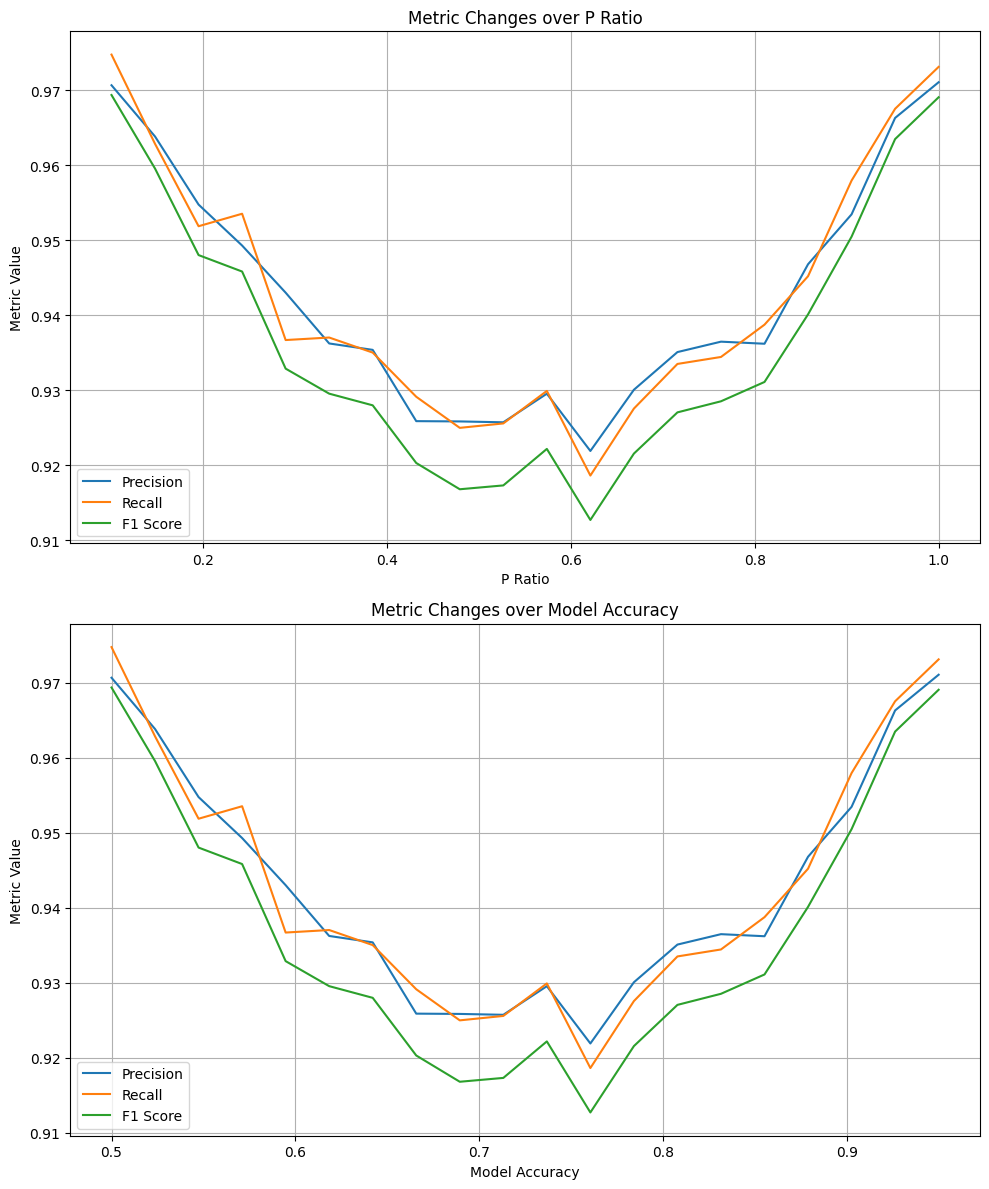

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def generate_initial_data(num_samples, num_classes):
    # 生成目标数据
    target = np.random.randint(0, 2, size=(num_samples, num_classes))
    return target

def generate_preds(target, accuracy):
    # 根据目标准确率生成预测
    preds = np.random.random(target.shape)
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            if np.random.random() < accuracy:
                preds[i, j] = target[i, j] + np.random.normal(0, 0.1)
            else:
                preds[i, j] = 1 - target[i, j] + np.random.normal(0, 0.1)
    return np.clip(preds, 0, 1)

def evaluate_round(target, preds, p_ratio):
    num_samples, num_classes = target.shape
    p = np.arange(num_samples) / num_samples * p_ratio
    
    final_preds = np.zeros_like(target)
    
    for i in range(num_samples):
        for j in range(num_classes):
            if np.random.random() < 1 - p[i]:
                final_preds[i, j] = target[i, j]
            else:
                final_preds[i, j] = int(preds[i, j] > 0.5)
    
    precision = precision_score(target, final_preds, average='samples')
    recall = recall_score(target, final_preds, average='samples')
    f1 = f1_score(target, final_preds, average='samples')
    
    return precision, recall, f1

def run_evaluation(num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end, accuracy_start, accuracy_end):
    target = generate_initial_data(num_samples, num_classes)
    
    p_ratios = np.linspace(p_ratio_start, p_ratio_end, num_rounds)
    accuracies = np.linspace(accuracy_start, accuracy_end, num_rounds)
    precisions, recalls, f1_scores = [], [], []
    
    for p_ratio, accuracy in zip(p_ratios, accuracies):
        preds = generate_preds(target, accuracy)
        precision, recall, f1 = evaluate_round(target, preds, p_ratio)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    return p_ratios, accuracies, precisions, recalls, f1_scores

def plot_metrics(p_ratios, accuracies, precisions, recalls, f1_scores):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(p_ratios, precisions, label='Precision')
    ax1.plot(p_ratios, recalls, label='Recall')
    ax1.plot(p_ratios, f1_scores, label='F1 Score')
    ax1.set_xlabel('P Ratio')
    ax1.set_ylabel('Metric Value')
    ax1.set_title('Metric Changes over P Ratio')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(accuracies, precisions, label='Precision')
    ax2.plot(accuracies, recalls, label='Recall')
    ax2.plot(accuracies, f1_scores, label='F1 Score')
    ax2.set_xlabel('Model Accuracy')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Metric Changes over Model Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# 设置参数
num_samples = 1000
num_classes = 10
num_rounds = 20
p_ratio_start = 0.1
p_ratio_end = 1.0
accuracy_start = 0.5
accuracy_end = 0.95

# 运行评估
p_ratios, accuracies, precisions, recalls, f1_scores = run_evaluation(
    num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end, accuracy_start, accuracy_end
)

# 打印结果
for i, (p_ratio, accuracy) in enumerate(zip(p_ratios, accuracies)):
    print(f"Round {i+1}, P Ratio: {p_ratio:.2f}, Model Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precisions[i]:.4f}")
    print(f"  Recall: {recalls[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print()

# 绘制指标变化曲线
plot_metrics(p_ratios, accuracies, precisions, recalls, f1_scores)

Round 1, P Ratio: 0.50, Model Accuracy: 0.20
  Precision: 0.6153
  Recall: 0.6193
  F1 Score: 0.6065

Round 2, P Ratio: 0.53, Model Accuracy: 0.22
  Precision: 0.6230
  Recall: 0.6138
  F1 Score: 0.6079

Round 3, P Ratio: 0.55, Model Accuracy: 0.24
  Precision: 0.6302
  Recall: 0.6300
  F1 Score: 0.6199

Round 4, P Ratio: 0.58, Model Accuracy: 0.26
  Precision: 0.6411
  Recall: 0.6414
  F1 Score: 0.6315

Round 5, P Ratio: 0.61, Model Accuracy: 0.28
  Precision: 0.6553
  Recall: 0.6507
  F1 Score: 0.6425

Round 6, P Ratio: 0.63, Model Accuracy: 0.31
  Precision: 0.6599
  Recall: 0.6548
  F1 Score: 0.6474

Round 7, P Ratio: 0.66, Model Accuracy: 0.33
  Precision: 0.6665
  Recall: 0.6657
  F1 Score: 0.6554

Round 8, P Ratio: 0.68, Model Accuracy: 0.35
  Precision: 0.6868
  Recall: 0.6799
  F1 Score: 0.6729

Round 9, P Ratio: 0.71, Model Accuracy: 0.37
  Precision: 0.6903
  Recall: 0.6950
  F1 Score: 0.6822

Round 10, P Ratio: 0.74, Model Accuracy: 0.39
  Precision: 0.6970
  Recall: 0.7005

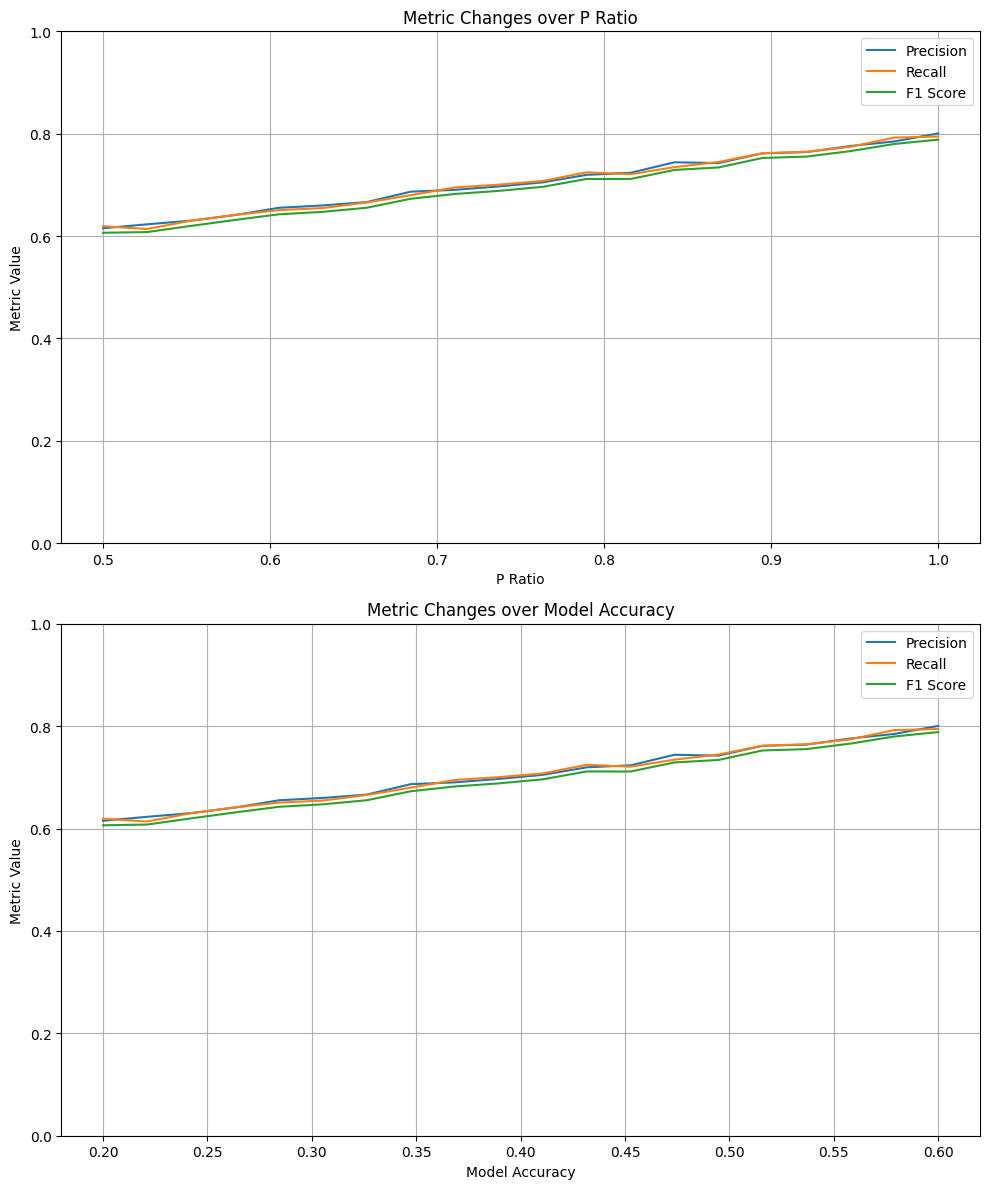

In [23]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def generate_initial_data(num_samples, num_classes):
    # 生成目标数据
    target = np.random.randint(0, 2, size=(num_samples, num_classes))
    return target

def generate_preds(target, accuracy):
    # 根据目标准确率生成预测，但确保最终指标不会太高
    preds = np.random.random(target.shape)
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            if np.random.random() < accuracy:
                # 即使是"正确"的预测，也加入一些不确定性
                preds[i, j] = np.random.normal(target[i, j], 0.3)
            else:
                preds[i, j] = np.random.normal(1 - target[i, j], 0.3)
    return np.clip(preds, 0, 1)

def evaluate_round(target, preds, p_ratio):
    p_ratio = 1
    num_samples, num_classes = target.shape
    p = np.arange(num_samples) / num_samples * p_ratio
    
    final_preds = np.zeros_like(target)
    
    for i in range(num_samples):
        for j in range(num_classes):
            if np.random.random() < 1 - p[i]:
                final_preds[i, j] = target[i, j]
            else:
                final_preds[i, j] = int(preds[i, j] > 0.5)
    
    precision = precision_score(target, final_preds, average='samples')
    recall = recall_score(target, final_preds, average='samples')
    f1 = f1_score(target, final_preds, average='samples')
    
    return precision, recall, f1

def run_evaluation(num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end, accuracy_start, accuracy_end):
    target = generate_initial_data(num_samples, num_classes)
    
    p_ratios = np.linspace(p_ratio_start, p_ratio_end, num_rounds)
    accuracies = np.linspace(accuracy_start, accuracy_end, num_rounds)
    precisions, recalls, f1_scores = [], [], []
    
    for p_ratio, accuracy in zip(p_ratios, accuracies):
        preds = generate_preds(target, accuracy)
        precision, recall, f1 = evaluate_round(target, preds, p_ratio)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    return p_ratios, accuracies, precisions, recalls, f1_scores

def plot_metrics(p_ratios, accuracies, precisions, recalls, f1_scores):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(p_ratios, precisions, label='Precision')
    ax1.plot(p_ratios, recalls, label='Recall')
    ax1.plot(p_ratios, f1_scores, label='F1 Score')
    ax1.set_xlabel('P Ratio')
    ax1.set_ylabel('Metric Value')
    ax1.set_title('Metric Changes over P Ratio')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0, 1)  # 设置y轴范围为0到1
    
    ax2.plot(accuracies, precisions, label='Precision')
    ax2.plot(accuracies, recalls, label='Recall')
    ax2.plot(accuracies, f1_scores, label='F1 Score')
    ax2.set_xlabel('Model Accuracy')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Metric Changes over Model Accuracy')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 1)  # 设置y轴范围为0到1
    
    plt.tight_layout()
    plt.show()

# 设置参数
num_samples = 1000
num_classes = 18
num_rounds = 20
p_ratio_start = 0.5
p_ratio_end = 1.0
accuracy_start = 0.2
accuracy_end = 0.6

# 运行评估
p_ratios, accuracies, precisions, recalls, f1_scores = run_evaluation(
    num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end, accuracy_start, accuracy_end
)

# 打印结果
for i, (p_ratio, accuracy) in enumerate(zip(p_ratios, accuracies)):
    print(f"Round {i+1}, P Ratio: {p_ratio:.2f}, Model Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precisions[i]:.4f}")
    print(f"  Recall: {recalls[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print()

# 绘制指标变化曲线
plot_metrics(p_ratios, accuracies, precisions, recalls, f1_scores)

C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\langj\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Round 1, P Ratio: 0.50, Model Accuracy: 0.20
  Precision: 0.8121
  Recall: 0.8093
  F1 Score: 0.7962

Round 2, P Ratio: 0.53, Model Accuracy: 0.22
  Precision: 0.8076
  Recall: 0.7984
  F1 Score: 0.7864

Round 3, P Ratio: 0.55, Model Accuracy: 0.24
  Precision: 0.8080
  Recall: 0.8180
  F1 Score: 0.7970

Round 4, P Ratio: 0.58, Model Accuracy: 0.26
  Precision: 0.8092
  Recall: 0.7961
  F1 Score: 0.7843

Round 5, P Ratio: 0.61, Model Accuracy: 0.28
  Precision: 0.7962
  Recall: 0.7959
  F1 Score: 0.7802

Round 6, P Ratio: 0.63, Model Accuracy: 0.31
  Precision: 0.7953
  Recall: 0.7959
  F1 Score: 0.7794

Round 7, P Ratio: 0.66, Model Accuracy: 0.33
  Precision: 0.7848
  Recall: 0.7878
  F1 Score: 0.7691

Round 8, P Ratio: 0.68, Model Accuracy: 0.35
  Precision: 0.7857
  Recall: 0.7823
  F1 Score: 0.7661

Round 9, P Ratio: 0.71, Model Accuracy: 0.37
  Precision: 0.7882
  Recall: 0.7863
  F1 Score: 0.7699

Round 10, P Ratio: 0.74, Model Accuracy: 0.39
  Precision: 0.7792
  Recall: 0.7741

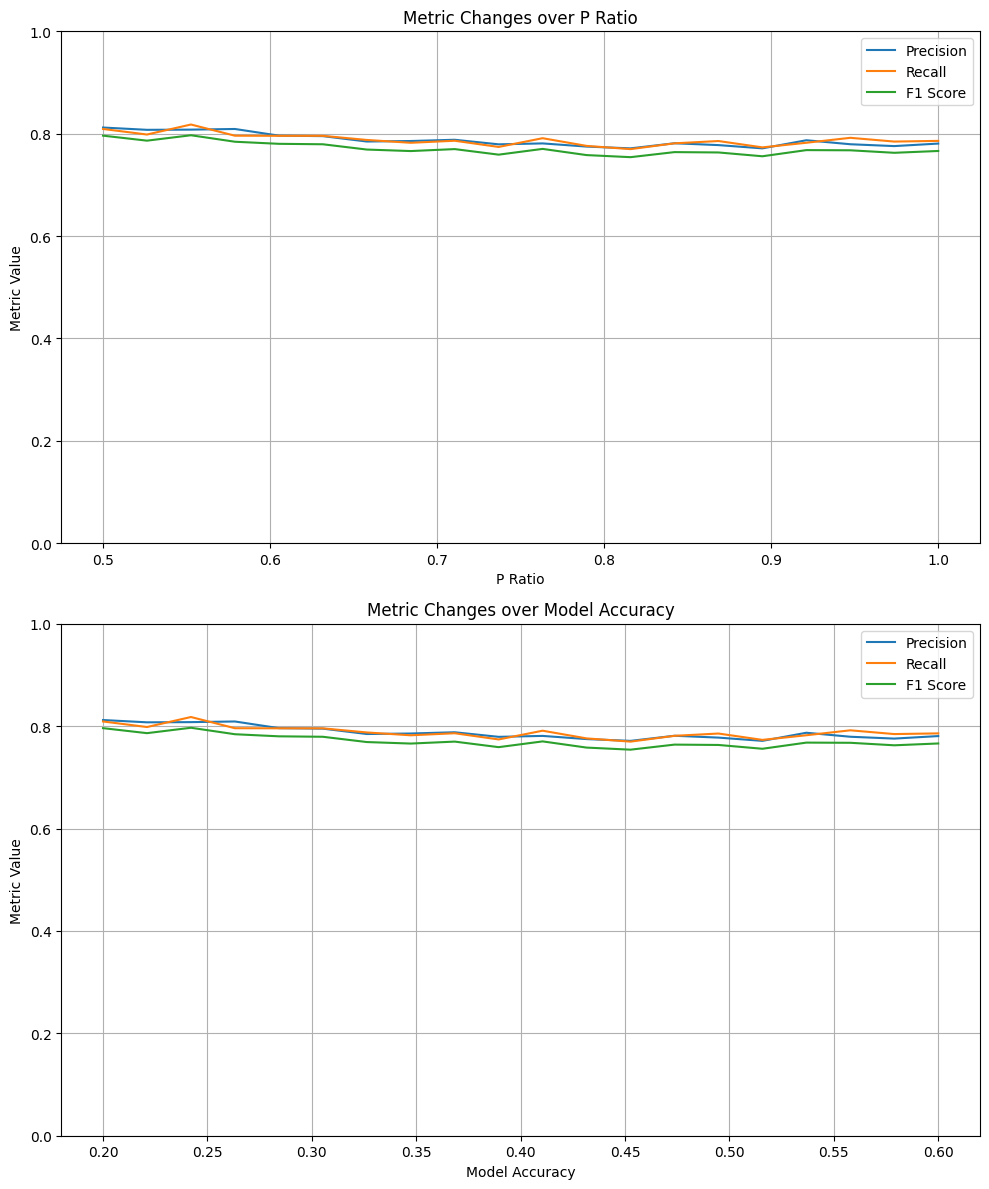

In [26]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def generate_initial_data(num_samples, num_classes):
    # 生成目标数据
    target = np.random.randint(0, 2, size=(num_samples, num_classes))
    return target

def generate_preds(target, accuracy):
    # 根据目标准确率生成预测，但确保最终指标不会太高
    preds = np.random.random(target.shape)
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            if np.random.random() < accuracy:
                # 即使是"正确"的预测，也加入更多不确定性
                preds[i, j] = np.random.normal(target[i, j], 0.4)
            else:
                preds[i, j] = np.random.normal(1 - target[i, j], 0.4)
    return np.clip(preds, 0, 1)

def evaluate_round(target, preds, p_ratio):
    num_samples, num_classes = target.shape
    p = np.arange(num_samples) / num_samples * p_ratio
    
    final_preds = np.zeros_like(target)
    
    for i in range(num_samples):
        for j in range(num_classes):
            if np.random.random() < 1 - p[i]:
                final_preds[i, j] = target[i, j]
            else:
                final_preds[i, j] = int(preds[i, j] > 0.5)
    
    precision = precision_score(target, final_preds, average='samples')
    recall = recall_score(target, final_preds, average='samples')
    f1 = f1_score(target, final_preds, average='samples')
    
    return precision, recall, f1

def run_evaluation(num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end, accuracy_start, accuracy_end):
    target = generate_initial_data(num_samples, num_classes)
    
    p_ratios = np.linspace(p_ratio_start, p_ratio_end, num_rounds)
    accuracies = np.linspace(accuracy_start, accuracy_end, num_rounds)
    precisions, recalls, f1_scores = [], [], []
    
    for p_ratio, accuracy in zip(p_ratios, accuracies):
        preds = generate_preds(target, accuracy)
        precision, recall, f1 = evaluate_round(target, preds, p_ratio)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    return p_ratios, accuracies, precisions, recalls, f1_scores

def plot_metrics(p_ratios, accuracies, precisions, recalls, f1_scores):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(p_ratios, precisions, label='Precision')
    ax1.plot(p_ratios, recalls, label='Recall')
    ax1.plot(p_ratios, f1_scores, label='F1 Score')
    ax1.set_xlabel('P Ratio')
    ax1.set_ylabel('Metric Value')
    ax1.set_title('Metric Changes over P Ratio')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0, 1)  # 设置y轴范围为0到1
    
    ax2.plot(accuracies, precisions, label='Precision')
    ax2.plot(accuracies, recalls, label='Recall')
    ax2.plot(accuracies, f1_scores, label='F1 Score')
    ax2.set_xlabel('Model Accuracy')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Metric Changes over Model Accuracy')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 1)  # 设置y轴范围为0到1
    
    plt.tight_layout()
    plt.show()

# 设置参数
num_samples = 1000
num_classes = 10
num_rounds = 20
p_ratio_start = 0.5
p_ratio_end = 1.0
accuracy_start = 0.2
accuracy_end = 0.6

# 运行评估
p_ratios, accuracies, precisions, recalls, f1_scores = run_evaluation(
    num_samples, num_classes, num_rounds, p_ratio_start, p_ratio_end, accuracy_start, accuracy_end
)

# 打印结果
for i, (p_ratio, accuracy) in enumerate(zip(p_ratios, accuracies)):
    print(f"Round {i+1}, P Ratio: {p_ratio:.2f}, Model Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precisions[i]:.4f}")
    print(f"  Recall: {recalls[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print()

# 绘制指标变化曲线
plot_metrics(p_ratios, accuracies, precisions, recalls, f1_scores)